## Reading in a datacube
Let's import some needed python modules and load the datacube file. These python modules can be found as part of astroconda. A description of the different extensions for the MaNGA CUBE files can be found in its datamodel.

In [40]:
import os     #importing some python modules
import numpy as np
import matplotlib.pyplot as plt
from astropy import wcs
from astropy.io import fits

cube = fits.open(r'/Users/runquanguan/Documents/manga-7443-12703-LOGCUBE.fits.gz')    
#assumes you are in the same directory as the cube file

# reading in and re-ordering FLUX, IVAR, and MASK arrays from (wavelength, y, x) to (x, y, wavelength).
flux = np.transpose(cube['FLUX'].data, axes=(2, 1, 0))
ivar = np.transpose(cube['IVAR'].data, axes=(2, 1, 0))
mask = np.transpose(cube['MASK'].data, axes=(2, 1, 0))

wave = cube['WAVE'].data   #reading in wavelength
flux_header = cube['FLUX'].header   #reading in the header of the flux extension

Note: For convenience, we have reordered the axes of the data arrays to the intended ordering of (x,y,λ); see the discussion of array indexing on the Caveats page. In the flux, ivar, and mask arrays, (x=0, y=0) corresponds to the upper left if North is up and East is left.

Try looking at the shapes of the transposed arrays to get a better understanding of the how the cube files look.

In [41]:
print(flux.shape)   #should print (74, 74, 4563)
print(ivar.shape)   #should print (74, 74, 4563)
print(mask.shape)   #should print (74, 74, 4563)
print(wave.shape)   #should print (4563,)

(74, 74, 4563)
(74, 74, 4563)
(74, 74, 4563)
(4563,)


This cube is 74 by 74 spatial pixels (spaxels) and there are 4563 spectral pixels in wavelength. Each position in x and y has a full spectrum, hence a datacube!
## Plot a spectrum from a datacube
Let's plot the central spectrum of the datacube.

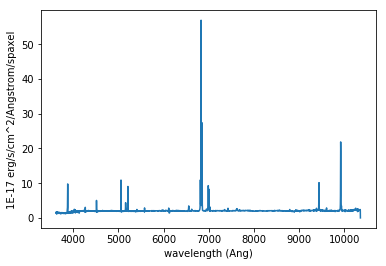

In [42]:
x_center = np.int(flux_header['CRPIX1']) - 1   #finding the middle pixel in x
y_center = np.int(flux_header['CRPIX2']) - 1   #finding the middle pixel in y

plt.plot(wave, flux[x_center, y_center])
plt.xlabel('wavelength (Ang)')
plt.ylabel(flux_header['BUNIT'])
plt.show()

Try plotting the flux at other positions in the cube, other than the center. Remember that the MaNGA IFU field of view is a hexagon, so in the corners and some edges there will not be any flux.
## Find array indices in CUBE of a particular RA and DEC
We can use the wcs package in astropy to map between cube indices and right ascension (RA) and declination (dec) using the information given in the flux header. In this example, we want to find what spaxel corresponds to a given RA and dec.

In [45]:
cubeWCS = wcs.WCS(flux_header)
ra = 229.525580000   #desired RA
dec = 42.7458420000  #desired dec
x_cube_coord, y_cube_coord, __ = cubeWCS.wcs_world2pix([[ra, dec, 1.]], 1)[0]
x_spaxel = np.int(np.round(x_cube_coord)) - 1  #corresponding x spaxel position
y_spaxel = np.int(np.round(y_cube_coord)) - 1  #corresponding x spaxel position
print(x_spaxel,y_spaxel)

37 37


## Plot an H narrow band image from the datacube
Here we will plot a H map, or narrow band image, from the datacube. It is good practice to apply the bitmasks.

In [46]:
do_not_use = (mask & 2**10) != 0   #finding the bad spaxels
flux_m = np.ma.array(flux, mask=do_not_use)  #new masked flux array

#Using the redshift of the galaxy, we can select the wavelength region around H

redshift = 0.0402719   #redshift of this galaxy
ind_wave = np.where((wave / (1 + redshift) > 6550) & (wave / (1 + redshift) < 6680))[0]  #finding the wavelegth range around H$\alpha$
halpha = flux_m[:, :, ind_wave].sum(axis=2)   #summing the fluxes at each spaxel in the wavelength range
im = halpha.T

# Convert from array indices to arcsec relative to IFU center
dx = flux_header['CD1_1'] * 3600.  # deg to arcsec
dy = flux_header['CD2_2'] * 3600.  # deg to arcsec
x_extent = (np.array([0., im.shape[0]]) - (im.shape[0] - x_center)) * dx * (-1)
y_extent = (np.array([0., im.shape[1]]) - (im.shape[1] - y_center)) * dy
extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]]

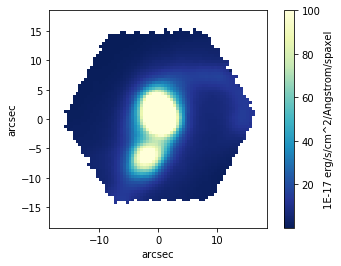

In [47]:
#Generate the H map:

plt.imshow(im, extent=extent, cmap=cm.YlGnBu_r, vmin=0.1, vmax=100, origin='lower', interpolation='none')
plt.colorbar(label=flux_header['BUNIT'])
plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.show()